In [1]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install opencv-contrib-python
!pip install tensorflow-addons
import os
import cv2
import time
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Layer, Input, Conv2D, BatchNormalization, Lambda, Concatenate
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
from tensorflow.keras.layers import Input, SeparableConv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import (
    Input, SeparableConv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Conv2DTranspose,
    Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, Add,
    GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda, Activation
)
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import Conv2D, Activation, Add, Multiply, UpSampling2D, Concatenate

from tensorflow.keras.regularizers import l2

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-c4em76cw
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-c4em76cw
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp311-cp311-linux_x86_64.whl size=3440339 sha256=295811c9f44c0d6d62727f4fd7ec45c351830c8e1417c04ca55406063862b80f
  Stored in directory: /tmp/pip-ephem-wheel-cache-0nz8i3k5/wheels/ce/8e/34/6dcfa200a9e2ae3627d8009b8bd1ca9b24512bec50a93304de
Successfully built pydensecrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Suc

2025-07-03 15:25:01.962811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751556302.167253      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751556302.223911      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

working_dir = '/kaggle/working'

# Duyệt qua toàn bộ file/thư mục trong /kaggle/working
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  # Xóa file hoặc symbolic link
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  # Xóa thư mục
            print(f"❌ xóa thành công {item_path}")
    except Exception as e:
        print(f"Lỗi khi xóa {item_path}: {e}")


❌ xóa thành công /kaggle/working/.virtual_documents


In [3]:
def load_isic_dataset(image_path, mask_path, binary_path, csv_file, img_size=(256, 256)):
    """
    Đọc và xử lý dữ liệu từ ISIC 2017 dataset

    Args:
        image_path: Đường dẫn đến thư mục chứa ảnh gốc
        mask_path: Đường dẫn đến thư mục chứa mask
        binary_path: Đường dẫn đến thư mục chứa mask nhị phân
        csv_file: Đường dẫn đầy đủ đến file CSV chứa nhãn
        label_name: Tên cột chứa nhãn trong file CSV
        img_size: Kích thước ảnh đầu ra (width, height)

    Returns:
        images: Numpy array chứa các ảnh đã xử lý
        masks: Numpy array chứa các mask đã xử lý
        binary_masks: Dict chứa mask nhị phân của từng ảnh đã xử lý
        image_ids: List các ID của ảnh
        labels: List các nhãn tương ứng với ảnh
    """

    # Lấy danh sách các file ảnh
    image_files = sorted(glob(os.path.join(image_path, "ISIC_*.jpg")))

    # Khởi tạo lists để lưu dữ liệu
    images = []
    masks = []
    binary_masks = {}
    image_ids = []
    labels = []

    # Đọc file CSV
    csv_data = pd.read_csv(csv_file)
    mel_label = csv_data['melanoma'].astype("int64")

    print("Đang đọc và xử lý dữ liệu...")
    for index, img_path in enumerate(tqdm(image_files)):
        # Lấy image ID
        img_id = os.path.basename(img_path).split('.')[0]
        mask_file = os.path.join(mask_path, f"{img_id}_segmentation.png")
        binary_file = os.path.join(binary_path, f"{img_id}_features.json")

        # Kiểm tra file mask có tồn tại
        if not os.path.exists(mask_file):
            print(f"Không tìm thấy mask cho ảnh mặt nạ {img_id}_segmentation.png")
            continue
        if not os.path.exists(binary_file):
            print(f"Không tìm thấy mask nhị phân cho ảnh {img_id}_features.json")
            continue

        try:


            # Đọc ảnh gốc
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển từ BGR sang RGB


            # Đọc mask
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

            # Resize ảnh và mask
            img = cv2.resize(img, img_size)
            mask = cv2.resize(mask, img_size)

            # Normalize
            img = img / 255.0
            mask = mask / 255.0

            # Đọc mask nhị phân
            with open(binary_file, 'r') as f:
                binary_masks[img_id] = json.load(f)

            # Lấy nhãn tương ứng
            label = mel_label[index]

            # Thêm vào lists
            images.append(img)
            masks.append(mask)
            image_ids.append(img_id)
            labels.append(label.astype("long"))

        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {img_id}: {str(e)}")
            continue

    # Chuyển sang numpy arrays
    images = np.array(images)
    masks = np.array(masks)[..., np.newaxis]  # Thêm channel dimension cho masks
    labels = np.array(labels)

    print(f"\nĐã đọc thành công {len(images)} ảnh")
    print(f"Shape của images: {images.shape}")
    print(f"Shape của masks: {masks.shape}")
    print(f"Shape của labels: {labels.shape}")

    return images, masks, binary_masks, image_ids, labels

In [4]:
# Đọc tập training
train_images, train_masks, train_binarys, train_image_ids, train_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2017-melanoma/Train_Data',
    mask_path='/kaggle/input/isic-2017-melanoma/Train_GroundTruth_1',
    binary_path='/kaggle/input/isic-2017-melanoma/Train_GroundTruth_2',
    csv_file="/kaggle/input/isic-2017-melanoma/Train_GroundTruth_3.csv",
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 635/635 [02:05<00:00,  5.06it/s]



Đã đọc thành công 635 ảnh
Shape của images: (635, 256, 256, 3)
Shape của masks: (635, 256, 256, 1)
Shape của labels: (635,)


In [5]:
test_images, test_masks, test_binarys, test_image_ids, test_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2017-melanoma/Test_Data',
    mask_path='/kaggle/input/isic-2017-melanoma/Test_GroundTruth_1',
    binary_path='/kaggle/input/isic-2017-melanoma/Test_GroundTruth_2',
    csv_file='/kaggle/input/isic-2017-melanoma/Test_GroundTruth_3.csv',
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 272/272 [00:46<00:00,  5.81it/s]


Đã đọc thành công 272 ảnh
Shape của images: (272, 256, 256, 3)
Shape của masks: (272, 256, 256, 1)
Shape của labels: (272,)


In [6]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou

In [7]:
def compute_metric(y_true, y_pred, metric='dice_coefficient', smooth=1e-6, is_numpy=False):
    """Tính Dice hoặc Jaccard coefficient/loss cho TensorFlow hoặc NumPy."""
    y_true_f = y_true.flatten() if is_numpy else K.flatten(y_true)
    y_pred_f = y_pred.flatten() if is_numpy else K.flatten(y_pred)
    intersection = np.sum(y_true_f * y_pred_f) if is_numpy else K.sum(y_true_f * y_pred_f)

    if 'dice' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        score = (2. * intersection + smooth) / (sum_fn(y_true_f) + sum_fn(y_pred_f) + smooth)
    elif 'jaccard' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        union = sum_fn(y_true_f) + sum_fn(y_pred_f) - intersection
        score = (intersection + smooth) / (union + smooth)
    else:
        raise ValueError(f"Unsupported metric: {metric}")

    return score if 'coefficient' in metric else 1 - score

# Hàm TensorFlow
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth)

def jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth)

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_loss', smooth)

# Hàm NumPy
def np_accuracy(y_true, y_pred):
    return np.mean(y_true.flatten() == y_pred.flatten())

def np_dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth, is_numpy=True)

def np_jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth, is_numpy=True)

def np_dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth, is_numpy=True)

In [8]:
def fam_module(input_features):
    """
    Feature Attention Module (FAM) với channel attention và spatial attention.
    """
    filters = input_features.shape[-1]

    # Channel Attention
    avg_pool = GlobalAveragePooling2D()(input_features)
    max_pool = GlobalMaxPooling2D()(input_features)

    # MLP cho channel attention
    dense1 = Dense(filters // 8, activation='relu')
    dense2 = Dense(filters, activation='sigmoid')

    avg_out = dense2(dense1(avg_pool))
    max_out = dense2(dense1(max_pool))

    # Kết hợp channel attention
    channel_attention = Add()([avg_out, max_out])
    channel_attention = Reshape((1, 1, filters))(channel_attention)
    channel_refined = Multiply()([input_features, channel_attention])

    # Spatial Attention
    # Sử dụng Lambda layer với Keras backend operations
    avg_spatial = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(channel_refined)
    max_spatial = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(channel_refined)
    spatial_concat = Concatenate()([avg_spatial, max_spatial])

    # Convolution để tạo spatial attention map
    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(spatial_concat)
    refined_features = Multiply()([channel_refined, spatial_attention])

    return refined_features

def CustomSegUNet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # ============= Encoder =============
    # Block 1
    c1 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(inputs)
    c1 = BatchNormalization()(c1)
    c1 = ReLU()(c1)
    c1 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c1)
    c1 = BatchNormalization()(c1)
    c1 = ReLU()(c1)
    c1 = SpatialDropout2D(0.1)(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p1)
    c2 = BatchNormalization()(c2)
    c2 = ReLU()(c2)
    c2 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c2)
    c2 = BatchNormalization()(c2)
    c2 = ReLU()(c2)
    c2 = SpatialDropout2D(0.1)(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Block 3
    c3 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p2)
    c3 = BatchNormalization()(c3)
    c3 = ReLU()(c3)
    c3 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c3)
    c3 = BatchNormalization()(c3)
    c3 = ReLU()(c3)
    c3 = SpatialDropout2D(0.1)(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Block 4
    c4 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p3)
    c4 = BatchNormalization()(c4)
    c4 = ReLU()(c4)
    c4 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(c4)
    c4 = BatchNormalization()(c4)
    c4 = ReLU()(c4)
    c4 = SpatialDropout2D(0.1)(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Block 5
    c5 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(p4)
    c5 = BatchNormalization()(c5)
    c5 = ReLU()(c5)
    c5 = SpatialDropout2D(0.1)(c5)
    p5 = MaxPooling2D((2, 2))(c5)

    # ============= Bottleneck =============
    c6 = SeparableConv2D(1024, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal(), dilation_rate=(2, 2))(p5)
    c6 = BatchNormalization()(c6)
    c6 = ReLU()(c6)
    c6 = SpatialDropout2D(0.2)(c6)


    # ============= Decoder =============
    u7 = Conv2DTranspose(512, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c6)
    u7 = Concatenate()([u7, c5])
    c7 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u7)
    c7 = BatchNormalization()(c7)
    c7 = ReLU()(c7)
    c7 = fam_module(c7)

    u8 = Conv2DTranspose(512, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c7)
    u8 = Concatenate()([u8, c4])
    c8 = SeparableConv2D(512, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u8)
    c8 = BatchNormalization()(c8)
    c8 = ReLU()(c8)
    c8 = fam_module(c8)

    u9 = Conv2DTranspose(256, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c8)
    u9 = Concatenate()([u9, c3])
    c9 = SeparableConv2D(256, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u9)
    c9 = BatchNormalization()(c9)
    c9 = ReLU()(c9)
    c9 = fam_module(c9)

    u10 = Conv2DTranspose(128, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c9)
    u10 = Concatenate()([u10, c2])
    c10 = SeparableConv2D(128, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u10)
    c10 = BatchNormalization()(c10)
    c10 = ReLU()(c10)
    c10 = fam_module(c10)

    u11 = Conv2DTranspose(64, (3, 3), strides=2, padding='same', kernel_initializer=HeNormal())(c10)
    u11 = Concatenate()([u11, c1])
    c11 = SeparableConv2D(64, (3, 3), padding='same', depthwise_initializer=HeNormal(), pointwise_initializer=HeNormal())(u11)
    c11 = BatchNormalization()(c11)
    c11 = ReLU()(c11)
    c11 = fam_module(c11)


    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11)

    return Model(inputs=inputs, outputs=outputs)

# Khởi tạo và kiểm tra mô hình
if __name__ == "__main__":
    model = CustomSegUNet()
    model.summary()

I0000 00:00:1751556488.715318      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 256, 256, 64)   │            137 │ input_layer[0][0]      │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 256, 256, 64)   │          4,736 │ re_lu[0][0]            │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 256, 256, 64)   │              0 │ re_lu_1[0][0]          │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ spatial_dropout2d[0][… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 128, 128, 128)  │          8,896 │ max_pooling2d[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ separable_conv2d_2[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_3        │ (None, 128, 128, 128)  │         17,664 │ re_lu_2[0][0]          │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ separable_conv2d_3[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)       

 Total params: 11,382,769 (43.42 MB)

 Trainable params: 11,372,913 (43.38 MB)

 Non-trainable params: 9,856 (38.50 KB)

In [9]:
class EarlyStoppingByAccuracyChange(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', threshold=0.00001, patience=3, verbose=0):
        super(EarlyStoppingByAccuracyChange, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.best_accuracy = -float('inf')
        self.consecutive_stops = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is None:
            tf.get_logger().warning(
                'Early stopping requires %s available!', self.monitor
            )
            return

        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.wait = 0
            self.consecutive_stops = 0
        else:
            self.wait += 1
            accuracy_change = current_accuracy - self.best_accuracy
            if abs(accuracy_change) < self.threshold:
                self.consecutive_stops += 1
                if self.consecutive_stops >= self.patience:
                    if self.verbose > 0:
                        print(f"Epoch {epoch+1}: Early stopping triggered due to minimal accuracy change for {self.patience} epochs.")
                    self.model.stop_training = True
            else:
                self.consecutive_stops = 0

In [10]:
pip install opencv-contrib-python


Note: you may need to restart the kernel to use updated packages.


In [11]:
def convert_to_gray_gaus(images):
    grays = []

    for img in images:
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        blurred = cv2.GaussianBlur(img, (5, 5), 0)
        img_gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
        grays.append(img_gray)

    return np.array(grays)

train_images_gray_gaus = convert_to_gray_gaus(train_images)
test_images_gray_gaus = convert_to_gray_gaus(test_images)
# Gọi hàm
# train_images_gray_clahe = convert_to_gray_clahe(train_images)
# test_images_gray_gaus = convert_to_gray_clahe(test_images)

In [12]:
initial_lr = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_lr, decay_steps=100000, decay_rate=0.96, staircase=True)

optimizer = Adam(learning_rate=initial_lr)


segunet = CustomSegUNet(input_size=(256, 256, 1))
segunet.compile(
    optimizer=optimizer,
    loss=dice_loss,
    metrics=['accuracy', jaccard_coefficient]
)

# Thiết lập thư mục lưu mô hình
model_checkpoint_dir = 'model'
# os.makedirs(model_checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(model_checkpoint_dir, 'cp.ckpt')

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_checkpoint_dir, 'custom_seg_unet.weights.h5'),
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Callback theo dõi train accuracy thay vì validation loss/accuracy
early_stopping = EarlyStoppingByAccuracyChange(
    monitor='accuracy',
    threshold=0.00001,
    patience=10,
    verbose=1
)
# ReduceLROnPlateau Callback
lr_reduction = ReduceLROnPlateau(monitor='loss',
                                  patience=5,
                                  verbose=1,
                                  factor=0.5,
                                  min_lr=0.00001)


# --- Tính thời gian huấn luyện ---
start_time = time.time()

# Huấn luyện mô hình
history = segunet.fit(
    train_images_gray_gaus, train_masks,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, lr_reduction, checkpoint_callback]
)

end_time = time.time()
training_time = end_time - start_time

# --- Tính trung bình Accuracy và Jaccard ---
avg_accuracy = np.mean(history.history['accuracy'])
avg_jaccard = np.mean(history.history['jaccard_coefficient'])

# --- In kết quả ---
print("SegUNet output shape:", segunet.output_shape)
print(f"⏱️ Thời gian huấn luyện: {training_time:.2f} giây")
print(f"✅ Accuracy trung bình: {avg_accuracy*100:.2f}%")
print(f"🔗 Jaccard trung bình: {avg_jaccard*100:.2f}%")

Epoch 1/100


I0000 00:00:1751556524.525050     186 service.cc:148] XLA service 0x7cb0cc002b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751556524.525918     186 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751556527.208592     186 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751556549.025754     186 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751556549.251883     186 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751556550.015542     186 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751556550.2248

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.6741 - jaccard_coefficient: 0.2360 - loss: 0.6212

E0000 00:00:1751556595.328849     189 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751556595.568603     189 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751556600.261483     189 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751556600.501031     189 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751556609.143856     189 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6741 - jaccard_coefficient: 0.2384 - loss: 0.6183   
Epoch 1: loss improved from inf to 0.56174, saving model to model/custom_seg_unet.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.6741 - jaccard_coefficient: 0.2406 - loss: 0.6156 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7927 - jaccard_coefficient: 0.4459 - loss: 0.3856
Epoch 2: loss improved from 0.56174 to 0.35375, saving model to model/custom_seg_unet.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 647ms/step - accuracy: 0.7941 - jaccard_coefficient: 0.4475 - loss: 0.3840 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8438 - jaccard_coefficient: 0.5199 - loss: 0.3168
Epoch 3: loss improved from 0.35375 to 0.31455, saving model to model/custom_seg_unet.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 649ms/step - accuracy: 0.8440 - jaccard_coefficient: 0.5200 - loss: 0.3167 - learning

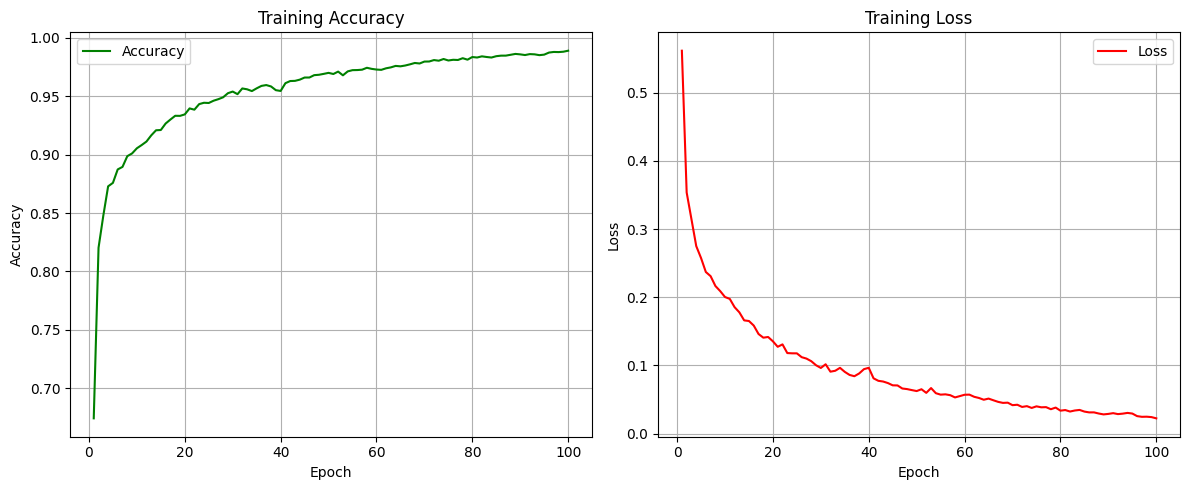

In [13]:
# Trích xuất dữ liệu từ lịch sử huấn luyện
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(acc) + 1)

# Vẽ biểu đồ Accuracy và Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()

# Lưu hình ảnh vào file PNG
plt.savefig('Gray_2750_1024Bottleneck_famedited.png', dpi=300)

# Hiển thị biểu đồ
plt.show()


In [14]:
# Hàm hậu xử lý bằng Morphological Operations
def apply_morphology(mask, kernel_size=3, iterations=1):
    """
    Morphological post-processing: closing -> opening để loại bỏ nhiễu và lỗ hổng.
    - kernel_size: Kích thước kernel (7).
    - iterations: Số lần áp dụng phép toán (1 or 2).
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask = (mask > 0.5).astype(np.uint8)  # Ngưỡng hóa trước

    # Closing để lấp lỗ hổng nhỏ
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    # Opening để loại bỏ nhiễu
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=iterations)

    return opened.astype(np.float32)  # Chuyển về float để tính toán metrics

print("🔍 Đánh giá không hậu xử lý...")
results = segunet.evaluate(test_images_gray_gaus, test_masks, verbose=1)
loss, accuracy, jaccard = results
print(f"Không hậu xử lý - Dice Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, Jaccard: {jaccard*100:.2f}%")

# Dự đoán và hậu xử lý chỉ với Morphological Operations
print("\n🔧 Đánh giá sau Morphology...")
predictions1 = segunet.predict(test_images_gray_gaus)
refined_predictions1 = []

for i in tqdm(range(len(test_images_gray_gaus))):
    pred = predictions1[i].squeeze()  # Loại bỏ chiều batch nếu cần

    # Áp dụng Morphological Operations
    morph_pred = apply_morphology(pred, kernel_size=7, iterations=2)

    refined_predictions1.append(morph_pred)

    # Lưu ảnh mẫu để so sánh
    # if i < 3:
    #     cv2.imwrite(f'before_morph_{i}.png', (pred > 0.5).astype(np.uint8) * 255)
    #     cv2.imwrite(f'after_morph_{i}.png', morph_pred * 255)

# Chuyển sang numpy array và thêm chiều channel nếu cần
refined_predictions1 = np.expand_dims(np.array(refined_predictions1), axis=-1)

# Tính toán metrics
accuracy_after = np_accuracy(test_masks, refined_predictions1)
jaccard_after = np_jaccard_coefficient(test_masks, refined_predictions1)
loss_after = np_dice_loss(test_masks, refined_predictions1)

print(f"Sau Morphology - Dice Loss: {loss_after:.4f}, Accuracy: {accuracy_after*100:.2f}%, Jaccard: {jaccard_after*100:.2f}%")

🔍 Đánh giá không hậu xử lý...
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 919ms/step - accuracy: 0.9242 - jaccard_coefficient: 0.7141 - loss: 0.1709
Không hậu xử lý - Dice Loss: 0.2022, Accuracy: 91.81%, Jaccard: 67.42%

🔧 Đánh giá sau Morphology...
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 742ms/step


100%|██████████| 272/272 [00:00<00:00, 1284.14it/s]


Sau Morphology - Dice Loss: 0.1852, Accuracy: 91.84%, Jaccard: 68.75%
